In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras import models, layers, datasets, optimizers

In [40]:
(train_data, train_targets), (test_data, test_targets) = datasets.boston_housing.load_data()

In [3]:
train_data.shape

(404, 13)

In [5]:
train_targets.shape

(404,)

In [6]:
type(train_data)

numpy.ndarray

In [7]:
train_data[0]

array([  1.23247,   0.     ,   8.14   ,   0.     ,   0.538  ,   6.142  ,
        91.7    ,   3.9769 ,   4.     , 307.     ,  21.     , 396.9    ,
        18.72   ])

In [8]:
#train data is a 2d tensor(matrix) 404x13 where the attributes repr.
#predictors like crime_rate, property_tax_rate, avg # of rooms, etc...
#GOAL: predict the median price of homes in a boston suburb
#data is old from the 1970's

In [9]:
test_data.shape

(102, 13)

In [10]:
train_targets[0]

15.2

In [11]:
#targets are continous numbers representing the median price in thousands of $
#max house price in training set
train_targets.max()

50.0

In [13]:
#min median price in training targets set
train_targets.min()

5.0

In [14]:
#sum of all house prices in training target set
train_targets.sum()

9047.599999999999

In [16]:
#avergae median house price in training target set
train_targets.mean()

22.395049504950492

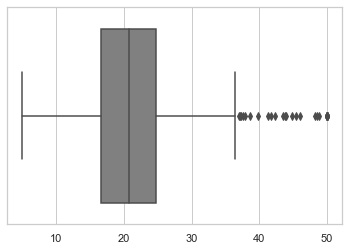

In [22]:
#box plot for training targets data using seaborn libray
sns.set_theme(style='whitegrid')
ax = sns.boxplot(x=train_targets)

In [23]:
#feature-wise normalization technique to improve learning process
#to reduce the range of values for each col(feature) in our 2d matrix of input
#subtract the mean of the feature and divide by the standard deviation
#the goal is to center each feature around 0 and have unit std(1)

In [29]:
mean = train_data.mean(axis=0) #array of 12 means, mean for each feature(col)
train_data -= mean #matrix addition(subtract the mean from each feature)
std = train_data.std(axis=0) #array of 12 stds, std for each feature(col)
train_data /= std

#do the same for test data using the means, and std calculated from training
test_data -= mean
test_data /= std

In [33]:
#building the neural network sequential model for regression purposes
#input layer is a 13-D column vector representing each samples features
#2 hidden layers each with 64 neurons, ReLU Activation
#output layer: single neuron no activation function(typical for scalar regr.)
#since our dataset is small, use a small neural network to prevent overfiiting

def build_model():
    model = models.Sequential()
    
    model.add(layers.Dense(64, activation='relu', input_shape=(13,)))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(1))
    
    #using SGD variant RMSProp, mean squared error(MSE) as loss score
    #metric is mean absolute error(MAE)
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
    #an MAE = 0.5 means predictions are off by $500 on average
    
    return model

In [34]:
#using K-FOLDS CROSS VALIDATION Method to get average evaluation
#since we partition our data randomly our accuracy evals will vary.
#K-FOLDS partitions training set into K equal parts, and uses K-1 parts
#for training

k = 4 # the # of equal splits in our training data
num_val_samples = len(train_data) // k # of samples per split
num_epochs = 100
all_scores = [] # a python list to store our 4 evaluation scores for each fold

for i in range(k):
    print(f'Processing fold #{i}')
    val_data = train_data[i*num_val_samples:(i+1)*num_val_samples]
    val_targets = train_targets[i*num_val_samples:(i+1)*num_val_samples]
    
    partial_train_data = np.concatenate([train_data[:i*num_val_samples], train_data[(i+1)*num_val_samples:]], axis=0)
    partial_train_targets = np.concatenate([train_targets[:i*num_val_samples], train_targets[(i+1)*num_val_samples:]], axis=0)
    
    model = build_model()
    model.fit(partial_train_data, partial_train_targets, epochs=num_epochs, batch_size=1, verbose=0)
    
    val_mse, val_mae = model.evaluate(val_data, val_targets, verbose=0)
    all_scores.append(val_mae)

Processing fold #0
Processing fold #1
Processing fold #2
Processing fold #3


In [35]:
all_scores

[2.6866374015808105, 2.60843563079834, 2.7778663635253906, 2.4895949363708496]

In [36]:
np.mean(all_scores) #avg evaluation score
#we are off by $2.6k on average

2.6406335830688477

In [37]:
all_mae_histories = []
num_epochs = 500

for i in range(k):
    print(f'Processing fold #{i}')
    val_data = train_data[i*num_val_samples:(i+1)*num_val_samples]
    val_targets = train_targets[i*num_val_samples:(i+1)*num_val_samples]
    
    partial_train_data = np.concatenate([train_data[:i*num_val_samples], train_data[(i+1)*num_val_samples:]], axis=0)
    partial_train_targets = np.concatenate([train_targets[:i*num_val_samples], train_targets[(i+1)*num_val_samples:]], axis=0)
    
    model = build_model()
    history = model.fit(partial_train_data, partial_train_targets, validation_data=(val_data, val_targets), epochs=num_epochs, batch_size=1, verbose=0)
    mae_history = history.history['val_mean_absolute_error']
    
    all_mae_histories.append(mae_history)


Processing fold #0


KeyError: 'val_mean_absolute_error'

In [38]:
#Computing Avg of the per-epoch MAE(mean absolute error) scores for all folds

#skippping for now, build the final model 


In [45]:
model = build_model()
model.fit(train_data, train_targets, epochs=80, batch_size=16, verbose=0)
test_mse_score, test_mae_score = model.evaluate(test_data, test_targets)

4/4 [==============================] - 0s 1ms/step - loss: 28.8534 - mae: 3.6755


In [42]:
print(test_mse_score, test_mae_score)

33.19147491455078 4.016805648803711


In [46]:
"""
MAIN TAKE AWAY FROM THIS REGRESSION PROBLEMS
->TYPICAL LOSS FUNCTION FOR REGRESSION: MSE(MEAN SQUARED ERROR)
->TYPICAL EVAL METRICS FOR REGRESSION: MAE(MEAN ABSOLUTE ERROR)
->WHEN FEATURES IN THE INPUT DATA HAVE VALUES THAT RANGE WIDELY, SCALE EACH
->FEATURE DOWN INDEPENDENTLY, SUBTRACT BY MEAN, DIVIDE BY SD
->USE K-FOLDS CROSS VALIDATION TO RELIABLY EVALUATE A MODEL
->WHEN LITTLE TRAINING DATA IS AVAILABLE USE A SMALL NETWORK WITH FEW HIDDEN
->LAYERS
"""

'\nMAIN TAKE AWAY FROM THIS REGRESSION PROBLEMS\n->TYPICAL LOSS FUNCTION FOR REGRESSION: MSE(MEAN SQUARED ERROR)\n->TYPICAL EVAL METRICS FOR REGRESSION: MAE(MEAN ABSOLUTE ERROR)\n->WHEN FEATURES IN THE INPUT DATA HAVE VALUES THAT RANGE WIDELY, SCALE EACH\n->FEATURE DOWN INDEPENDENTLY, SUBTRACT BY MEAN, DIVIDE BY SD\n->USE K-FOLDS CROSS VALIDATION TO RELIABLY EVALUATE A MODEL\n->WHEN LITTLE TRAINING DATA IS AVAILABLE USE A SMALL NETWORK WITH FEW HIDDEN\n->LAYERS\n'

In [48]:
df = pd.DataFrame(train_data)

In [49]:
df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,1.23247,0.0,8.14,0.0,0.538,6.142,91.7,3.9769,4.0,307.0,21.0,396.90,18.72
1,0.02177,82.5,2.03,0.0,0.415,7.610,15.7,6.2700,2.0,348.0,14.7,395.38,3.11
2,4.89822,0.0,18.10,0.0,0.631,4.970,100.0,1.3325,24.0,666.0,20.2,375.52,3.26
3,0.03961,0.0,5.19,0.0,0.515,6.037,34.5,5.9853,5.0,224.0,20.2,396.90,8.01
4,3.69311,0.0,18.10,0.0,0.713,6.376,88.4,2.5671,24.0,666.0,20.2,391.43,14.65


In [50]:
np_array = np.array(df)

In [51]:
np_array

array([[1.23247e+00, 0.00000e+00, 8.14000e+00, ..., 2.10000e+01,
        3.96900e+02, 1.87200e+01],
       [2.17700e-02, 8.25000e+01, 2.03000e+00, ..., 1.47000e+01,
        3.95380e+02, 3.11000e+00],
       [4.89822e+00, 0.00000e+00, 1.81000e+01, ..., 2.02000e+01,
        3.75520e+02, 3.26000e+00],
       ...,
       [3.46600e-02, 3.50000e+01, 6.06000e+00, ..., 1.69000e+01,
        3.62250e+02, 7.83000e+00],
       [2.14918e+00, 0.00000e+00, 1.95800e+01, ..., 1.47000e+01,
        2.61950e+02, 1.57900e+01],
       [1.43900e-02, 6.00000e+01, 2.93000e+00, ..., 1.56000e+01,
        3.76700e+02, 4.38000e+00]])